In [30]:
import ImageRepresentation
import ThesisToolkit
from ThesisToolkit import FeaturesIOToolkit as featuresIO
import numpy as np
import cv2 as cv
import os
import joblib
%matplotlib inline
from matplotlib import pyplot as plt 
from matplotlib import image as img

In [59]:
query_path = "/mnt/datasets/kakao_queries_delf_vlad256/queries.npy"
query_index_path = "/mnt/datasets/kakao_queries_delf_vlad256/indexes.npy"
query_image_dir = "/mnt/datasets/kakao_queries/"
database_path = "/mnt/datasets/daejeon520_vlad256_delf/database.npy"
database_index_path = "/mnt/datasets/daejeon520_vlad256_delf/indexes.npy"
database_image_dir = "/mnt/datasets/daejeon520/"
codebook_model = "/mnt/datasets/codebook_520/delf_256_model_epoc_0.pkl"

In [32]:
queries = np.load(query_path)
query_indexes = np.load(query_index_path)
database = np.load(database_path)
database_indexes = np.load(database_index_path)
print(queries.shape)

(101, 10240)


In [70]:
def retrieve(query_index, query, top_ranks = 50):
    scores = np.dot(database, query)
    indices = np.argpartition(-scores, kth=range(top_ranks))[:top_ranks]
    rank_list = database_indexes[indices]
    return rank_list

ref_file = "/mnt/datasets/kakao_queries_30m.csv"
with open(ref_file) as f:
    contents = f.readlines()
lines = [x.strip('\n') for x in contents]
ref = dict()
for line in lines:
    tup = line.split(',')
    ref[tup[0]] = set(tup[1:])

In [81]:
# single image test
test_index = 37
print(queries[test_index])
rank_list = retrieve(query_indexes[test_index], queries[test_index])
print(query_indexes[test_index])
print("Retrieval result:")
for i in range(len(rank_list)):
    if(rank_list[i][:-2] in ref[query_indexes[test_index]]):
        print(rank_list[i],1)
    else:
        print(rank_list[i],0)

[ 0.02382684  0.01026541  0.02246    ... -0.00992623  0.00057672
  0.00049451]
39
Retrieval result:
_kHg6J9QL2LENDgvII5aK4w_3 0
_b5B3PtprplM6aKURap7ttg_3 0
_MRptcv94Hu1NAGLqTrqyTQ_3 0
_JZ_UZVSJ3Foi6jg53n4AeA_3 0
_MRptcv94Hu1NAGLqTrqyTQ_4 0
_0HZsuA9vD94tUvgwwfncbg_1 0
_9oL7Ft60ampAAe5Y4jaLyA_3 0
_OGAwV4lP5fpxIsAkI_VPLw_0 0
_beqyIBqMoRE_iMUYQ1mBnw_3 0
_EVU1g5o2Saf3zS5-TdNuRg_3 0
_ee40znGr6sKofKj0vOn2Ag_4 0
_EVU1g5o2Saf3zS5-TdNuRg_0 0
_OTNvgGRtNRZDKovbbq1KMQ_3 0
_tdJ8bUPVTZcc3hcx0vnFPQ_0 0
_OIQ4U0oxCdV5zcWxnY8VVw_0 0
_MRptcv94Hu1NAGLqTrqyTQ_1 0
_4DA29QK-G6VR1ngQ4BbyzA_1 0
_8yFo5mURqrtGR4NvWxMwzg_3 0
_VNzty9e1gf-2FEvN6_QRpQ_0 0
_wvDcVFwOrI3_S3mz5aGrVQ_4 0
_C5Nvl1zT40ycnwn1MZlOdg_3 0
_uwhp5KbXdVFlPlRz9MA8aQ_1 0
_kHg6J9QL2LENDgvII5aK4w_1 0
_kHg6J9QL2LENDgvII5aK4w_4 0
_S-X7QoMx2IL8KclK36lRrw_7 0
_EIdhyfe3zU9sBTrGLkOTDw_0 0
_2xfr_3H94rHviZcrpl7ieg_0 0
_SrUlEPt-Ny9k9kpILW7nXg_0 0
_1YLldlMJDwCuL4YM5tjbPQ_0 0
_PRtvlYJH0RpK0QvZ7qLyFA_4 0
_X1mPbSqGKpfDzY-LSL_oYQ_3 0
_DF1TW_34HZYrV9M1Nu-qsg_0 0
_ZEt

In [43]:
# large scale benchmark
scores = np.dot(database, np.transpose(queries))
print(scores.shape)

(259016, 101)


In [44]:
# a = np.array([[0,1,3,2,4,6,5],[0,1,2,4,5,6,3]])
# s = np.argpartition(-a, kth=range(4), axis=1)
# print(s)
# # s = s.T[:3].T
# # print(s)
# b = np.array([1,2,3,4,5,6,7,8])
# print(b[s])

top_rank = 50
indices = np.argpartition(-scores, kth=range(top_rank), axis=0)
print(indices.shape)
sort_lists = indices[:top_rank].T
rank_lists = database_indexes[sort_lists]
print(rank_lists.shape)

(259016, 101)
(101, 50)


65 13 3 0 20
[0.64356436 0.71287129 0.74257426 0.74257426 0.77227723 0.77227723
 0.77227723 0.78217822 0.8019802  0.8019802  0.8019802  0.8019802
 0.8019802  0.8019802  0.8019802  0.8019802  0.8019802  0.8019802
 0.8019802  0.8019802 ]
[0.64356436 0.61881188 0.56765677 0.54207921 0.51683168 0.48514851
 0.45968883 0.44554455 0.42464246 0.40594059 0.39063906 0.37128713
 0.35567403 0.3437058  0.33333333 0.32487624 0.31683168 0.30693069
 0.2970297  0.28960396]


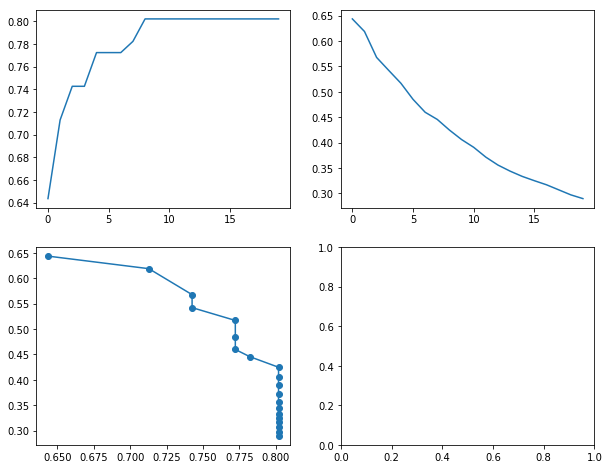

In [69]:
# Create true-false array from predict
results = []
for index, rank_list in zip(query_indexes, rank_lists):
    result = []
    for item in rank_list:
        if item[:-2] in ref[index]:
            result.append(1)
        else:
            result.append(0)
    results.append(np.array(result))

# list of heat map query
top_1_list = [] # list of query that have correct image at top-1
top_5_list = []
top_10_list = []
top_20_list = []
failed_list = []
# Recall calculation:
recall_results = []
for index, result in zip(query_indexes, results):
    recall_result = []
    first_correct = 0
    for item in result:
        if item == 1:
            for i in range(first_correct, len(result)):
                recall_result.append(1)
            break
        else:
            recall_result.append(0)
            first_correct += 1
    if first_correct <= 0:
        top_1_list.append(index)
    elif first_correct > 0 and first_correct <= 4:
        top_5_list.append(index)
    elif first_correct > 4 and first_correct <= 9:
        top_10_list.append(index)
    elif first_correct > 9 and first_correct <= 19:
        top_20_list.append(index)
    else: 
        failed_list.append(index)
    recall_results.append(np.array(recall_result))
print(len(top_1_list), len(top_5_list), len(top_10_list), len(top_20_list), len(failed_list))

top_retrieval = 20
recall = np.array([0]*top_retrieval)
for recall_result in recall_results:
    recall += recall_result[:top_retrieval]
recall = recall/float(len(queries))
print(recall)

# Precision
precision = []
precision_rank = np.array([0]*top_retrieval)
for result in results:
    precision_rank += result[:top_retrieval]
s = 0
for i in range(0,len(precision_rank)):
    s += precision_rank[i]
    
    precision.append(s/((i+1)*len(queries)))
print(np.array(precision))
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10,8)
axes[0,0].plot(recall)
axes[0,1].plot(precision)
axes[1,0].plot(recall, precision, marker = "o")

In [65]:
import shutil
from shutil import copy2
# load all database location to the mem
database_loc_file = "/mnt/datasets/daejeon520.csv"
with open(database_loc_file, 'r') as fi:
    contents = fi.readlines()
lines = [line.strip('\n') for line in contents]
database_locs = {}
for line in lines:
    tup = line.split(',')
    database_locs[tup[0]] = (tup[1], tup[2])
# create the result:
result_dir = "/mnt/datasets/kakao_result/"
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
top_K = 5
for index, rank_list, result in zip(query_indexes, rank_lists, results):
    # create the folder for this query
    q_dir = os.path.join(result_dir, str(index))
    if not os.path.exists(q_dir):
        os.makedirs(q_dir)
    else:
        shutil.rmtree(q_dir)
        os.makedirs(q_dir)
    # copy query image to the q_dir
    copy2(os.path.join(query_image_dir, str(index) + '.jpg'), q_dir)
    for i in range(top_K):
        copy2(os.path.join(database_image_dir, rank_list[i] + '.jpg'), q_dir)
    with open(os.path.join(q_dir, "index.csv"),"w") as fo:
        for i in range(top_K):
            latlng = database_locs[rank_list[i][:-2]]
            fo.write(rank_list[i] + ',' + str(latlng[0]) + ',' + str(latlng[1]) + ',' + str(result[i]))
            fo.write("\n")
